# Find changepoints in raw positions

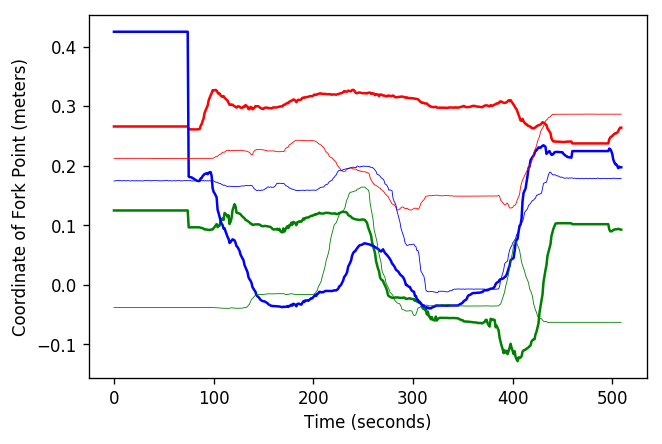

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(dpi= 120, facecolor='w', edgecolor='k')
#### read in the txt file
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
raw_data = np.loadtxt('../data/sharpened_spoon_poses.txt', delimiter=',')
#plt.plot(raw_data[:,(1,2,3,8,9,10)])
# Transform from second robot to frame of first robot
import transforms3d as t3d
q = [0, 0, 0, 1] # 180 degree rotation around z axis (w,x,y,z)
M = t3d.quaternions.quat2mat(q) # from this module
T = [[0.45, 0.06, 0]]
transform = np.concatenate((np.concatenate((M,np.transpose(T)),1),[[0,0,0,1]]))
# Plot the trajectories in the same coordinate frame
time = np.size(raw_data,0)
homogeneous_follower = np.transpose(np.concatenate((raw_data[:,1:4],np.ones((time,1))),1))
follower = np.transpose(np.dot(transform, homogeneous_follower))
follower.shape
same_frame_data = np.concatenate((raw_data[:,8:11],follower[:,0:3]),1)
from cycler import cycler
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = cycler(color='rgb')
relevant_indices = range(0,len(raw_data))#range(250,400)#
plt.plot(raw_data[relevant_indices,8:11])
plt.plot(follower[relevant_indices,0:3],linewidth=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Coordinate of Fork Point (meters)");

# Model first arm

In [7]:
import sys
import numpy as np
sys.path.insert(0, "../scripts")
import changepoint_detector.gaussian_model as gm
import changepoint_detector.changepoint_detector as chd
num_variables=3
max_duration = len(relevant_indices) + 2
# set apriori parameters
apriori_n = 3
apriori_mean = np.zeros(num_variables)
apriori_ssd = np.ones(num_variables) * 2 / 100000

model_generator = gm.GaussianPredictor(num_variables, apriori_n, apriori_mean, apriori_n / 2, apriori_ssd / 2).Fit
reset_prob = 1/(300)
change_detector = chd.ChangepointDetector(raw_data[:,8:11], reset_prob, model_generator, max_duration)
result_probs = change_detector.ModelChangepoints()


[0, 75, 104, 139, 234, 274, 302, 383, 387, 431]

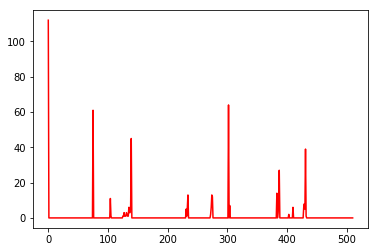

In [16]:
# early transition identification
maxtime = result_probs.shape[0]
min_trans_est = range(result_probs.shape[0]) - np.argmax(result_probs,1)
plt.plot([sum(min_trans_est == i) for i in range(maxtime)])
trans_starts = np.where(np.array([sum(min_trans_est == i) for i in range(maxtime)]) > 10)[0]
cleaned_trans_starts = []
for t in trans_starts:
    if t-1 not in cleaned_trans_starts:
        cleaned_trans_starts.append(t)
cleaned_trans_starts

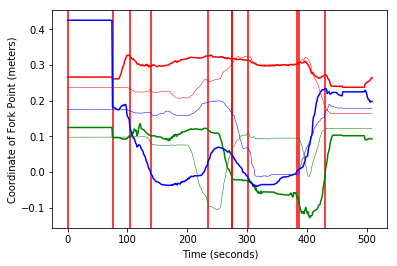

In [23]:
for i in trans_starts:
    plt.axvline(x=i)
plt.plot(raw_data[relevant_indices,8:11])
plt.plot(raw_data[relevant_indices,1:4],linewidth=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Coordinate of Fork Point (meters)");

In [19]:
def create_recording_file(raw_data, start_indx, end_indx, filename):
    row_id = start_indx
    with open("../data/%s" % filename,"w") as ofile:
        while row_id < end_indx:
            ofile.write("%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s\n" % tuple(raw_data[row_id,:]))
            row_id += 1

In [25]:
# ACQUIRE
create_recording_file(raw_data, cleaned_trans_starts[3],cleaned_trans_starts[4], "acquire_tomato.txt")
create_recording_file(raw_data, cleaned_trans_starts[5],420, "deposit_tomato.txt")